### Continuity


> Samples are needed for sequence models and transformer models for input


😈 **Task 1:** How does a basic MLP differ from models like RNNs or ARIMA when used for time series forecasting?

😈 **Question 1:** What challenges might arise when feeding sequences into a feedforward model like an MLP?



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96 
variable_columns = ["no2", "temp", "o3", "no", "press"]

In [1]:
import pickle

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (561969, 336, 5), y_train shape: (561969, 96, 5)
X_test shape: (140493, 336, 5), y_test shape: (140493, 96, 5)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [5]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

# Flatten input features
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # (samples, 24*5)
y_train_reshaped = y_train.reshape(X_train.shape[0], prediction_horizon * len(variable_columns))
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


In [7]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/1OBLsAElWT6BubRUtI3_cHTJVecrue5kG/view?usp=sharing 
# and the path needs to be updated to checkpoint_dir below:
checkpoint_dir = "./checkpoint/mlp_model_checkpoint_96/"
os.makedirs(checkpoint_dir, exist_ok=True)

num_variables = X_train.shape[2]
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
    print(f"\nTraining model for variable {var_idx + 1}/{num_variables}")

    X_train_single = X_train[:, :, var_idx]  # Shape: (562310, 24)
    y_train_single = y_train[:, :, var_idx]  # Shape: (562310, 6)
    X_test_single = X_test[:, :, var_idx]    # Shape: (140578, 24)

    y_train_single = y_train_single.reshape(y_train_single.shape[0], -1)

    # Model checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"mlp_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {var_idx + 1}")
        mlp_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {var_idx + 1}")

        # Build MLP model
        mlp_model = Sequential([
            Input(shape=(X_train_single.shape[1],)),  # 24 timesteps (context window)
            Dense(mlp_hidden_units[0], activation=activation_fn)
        ])

        for units in mlp_hidden_units[1:]:
            mlp_model.add(Dense(units, activation=activation_fn))

        mlp_model.add(Dense(y_train_single.shape[1]))  # 6 timesteps (pred horizon)
        mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train model
        training = mlp_model.fit(
            X_train_single, y_train_single,
            epochs=mlp_epochs, batch_size=mlp_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )
        training_histories[var_idx] = training.history

    y_pred_single = mlp_model.predict(X_test_single)
    mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], prediction_horizon, 5)  # Shape: (samples, 6, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)



Training model for variable 1/5
Loading existing model for variable 1
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 3s 727us/step



Training model for variable 2/5
Loading existing model for variable 2
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 3s 726us/step



Training model for variable 3/5
Loading existing model for variable 3
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 3s 775us/step



Training model for variable 4/5
Loading existing model for variable 4
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 4s 920us/step



Training model for variable 5/5
Loading existing model for variable 5
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 3s 750us/step


In [8]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, 5)
for var_idx in range(num_variables):
    y_test_single = y_test_reshaped[:, :, var_idx]
    y_pred_single = mlp_predictions[:, :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.9818
Variable temp:
RMSE: 1.0922
Variable o3:
RMSE: 1.1234
Variable no:
RMSE: 0.8384
Variable press:
RMSE: 1.0586


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


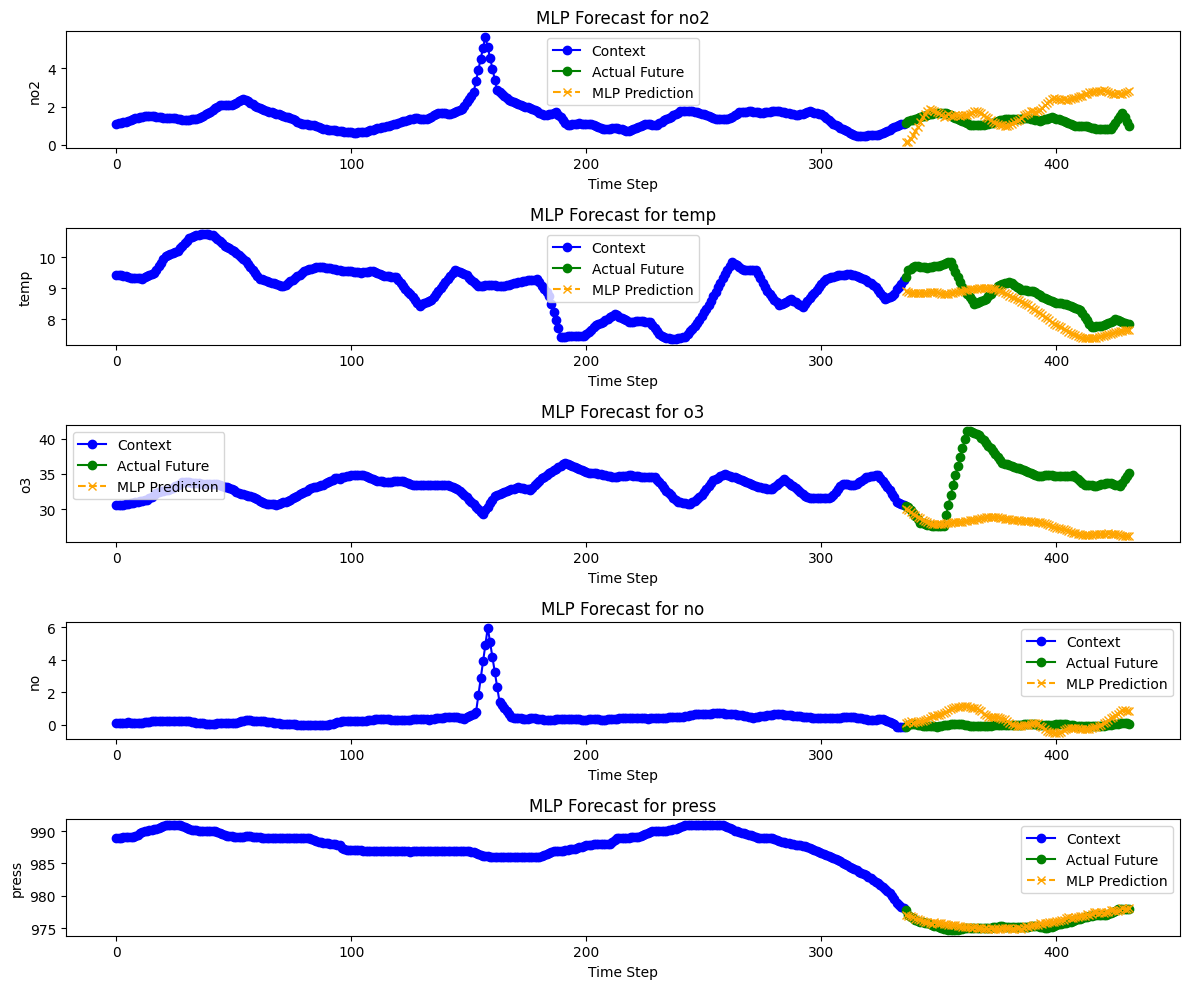

In [9]:
plt.figure(figsize=(12, 10))

for variable_idx in range(num_variables):
    mlp_model = load_model(
        os.path.join(checkpoint_dir, f"mlp_var{variable_idx}.h5"),
        custom_objects={"mse": MeanSquaredError()}
    )

    # Last sample
    sample_idx = -1
    X_test_sample = X_test[sample_idx, :, variable_idx]
    y_test_sample = y_test[sample_idx, :, variable_idx]

    # Predict
    mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1)).flatten()

    # Inverse scale 
    context = X_test_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']
    actual_future = y_test_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']
    predicted_future = mlp_pred_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']

    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_columns[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_columns[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()
